### Kaggle.com – Digits Recognition – Deep Version
https://www.kaggle.com/c/digit-recognizer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Model

In [2]:
class DigitsModel(object):
    
    def _create_weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def _create_bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def _create_conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    def _create_max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    def _init_model(self):    
        # input features
        self._x = tf.placeholder(tf.float32, shape=[None, 784])
        
        # reshape features to 2d shape
        self._x_image = tf.reshape(self._x, [-1,28,28,1])
        
        # known labels
        self._y_ = tf.placeholder(tf.float32, [None, 10])
        
        # layer 1
        self._W_conv_1 = self._create_weight_variable([5, 5, 1, 32])
        self._b_conv_1 = self._create_bias_variable([32])
        self._conv_1 = tf.nn.relu(self._create_conv2d(self._x_image, self._W_conv_1) + self._b_conv_1)
        self._pool_1 = self._create_max_pool_2x2(self._conv_1)
        
        # layer 2
        self._W_conv_2 = self._create_weight_variable([5, 5, 32, 64])
        self._b_conv_2 = self._create_bias_variable([64])
        self._conv_2 = tf.nn.relu(self._create_conv2d(self._pool_1, self._W_conv_2) + self._b_conv_2)
        self._pool_2 = self._create_max_pool_2x2(self._conv_2)
        
        # fully-connected layer
        # connects 3136 features (7*7*64) from _pool2 to 1024 _fc nodes
        self._W_fc_1 = self._create_weight_variable([7 * 7 * 64, 1024])
        self._b_fc_1 = self._create_bias_variable([1024])
        self._pool_2_flattened = tf.reshape(self._pool_2, [-1, 7 * 7* 64])
        self._fc_1 = tf.nn.relu(tf.matmul(self._pool_2_flattened, self._W_fc_1) + self._b_fc_1)
        
        # dropout layer
        self._keep_prob_1 = tf.placeholder(tf.float32) # how many features to keep (should be 1. in inference)
        self._dropout_1 = tf.nn.dropout(self._fc_1, self._keep_prob_1)
        
        # readout layer
        # 1024 features from _fc+_dropout -> 10 outputs
        self._W_readout = self._create_weight_variable([1024, 10])
        self._b_readout = self._create_bias_variable([10])
        self._readout = tf.nn.softmax(tf.matmul(self._dropout_1, self._W_readout) + self._b_readout)
        
    def _init_training(self):
        # loss function
        self._loss_fn = tf.reduce_mean(-tf.reduce_sum(self._y_ * tf.log(self._readout), reduction_indices=[1]))
        
        # ADAM solver, 0.0001 rate
        self._train_step = tf.train.AdamOptimizer(1e-4).minimize(self._loss_fn)
        
        # match predicted values against the correct ones
        self._prediction_matches = tf.equal(tf.argmax(self._readout, 1), tf.argmax(self._y_, 1))

        # accuracy metric
        self._accuracy = tf.reduce_mean(tf.cast(self._prediction_matches, tf.float32))
    
    def init(self):
        self._init_model()
        self._init_training()
        
        # init session
        i = tf.initialize_all_variables()
        self._sess = tf.Session()
        self._sess.run(i)
        
    def train_step(self, features_batch, labels_batch):
        feed_dict = {
                        self._x: features_batch,
                        self._y_: labels_batch,
                        self._keep_prob_1: 0.5
                    }
        self._sess.run(self._train_step, feed_dict=feed_dict)
        
    def get_accuracy(self, features, labels):
        feed_dict = {
                        self._x: features,
                        self._y_: labels,
                        self._keep_prob_1: 1.0
                    }
        return self._sess.run(self._accuracy, feed_dict=feed_dict)  
    
        
    def get_readout(self, features):
        feed_dict = {
                        self._x: features,
                        self._keep_prob_1: 1.0
                    }
        return self._sess.run(self._readout, feed_dict=feed_dict)  

#### Data Manipulation Helpers

In [3]:
# read features
def read_features_from_csv(filename, usecols=range(1,785)):
    features = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=usecols, dtype=np.float32)
    features = np.divide(features, 255.0) # scale 0..255 to 0..1
    return features

# read labels and convert them to 1-hot vectors
def read_labels_from_csv(filename):
    labels_orig = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=0, dtype=np.int)
    labels = np.zeros([len(labels_orig), 10])
    labels[np.arange(len(labels_orig)), labels_orig] = 1
    labels = labels.astype(np.float32)
    return labels

# generate batches
def generate_batch(features, labels, batch_size):
    batch_indexes = np.random.random_integers(0, len(features) - 1, batch_size)
    batch_features = features[batch_indexes]
    batch_labels = labels[batch_indexes]
    return (batch_features, batch_labels)

#### Prepare Data

In [4]:
# load data
features = read_features_from_csv('train.csv')
labels = read_labels_from_csv('train.csv')

In [23]:
# training params
BATCH_SIZE = 50
TRAIN_SPLIT = 0.85 # training/validation split
TRAINING_STEPS = int(len(features) * TRAIN_SPLIT / BATCH_SIZE * 33)

In [24]:
# split data into training and validation sets
train_samples = int(len(features) / (1 / TRAIN_SPLIT))
train_features = features[:train_samples]
train_labels = labels[:train_samples]
validation_features = features[train_samples:]
validation_labels = labels[train_samples:]

#### Run Training

In [25]:
model = DigitsModel()
model.init()

In [26]:
accuracy_history = []

for i in range(TRAINING_STEPS):  
    if i == 0 or (i + 1) % (TRAINING_STEPS // 33) == 0 or (i + 1) == TRAINING_STEPS:
        accuracy = model.get_accuracy(features=validation_features, labels=validation_labels)
        accuracy_history.append(accuracy)
        print 'step', i + 1, 'of', TRAINING_STEPS, '/ validation accuracy:', accuracy
        
    batch_features, batch_labels = generate_batch(train_features, train_labels, BATCH_SIZE)
    model.train_step(features_batch=batch_features, labels_batch=batch_labels)

step 1 of 23562 / validation accuracy: 0.136667
step 714 of 23562 / validation accuracy: 0.949365
step 1428 of 23562 / validation accuracy: 0.961746
step 2142 of 23562 / validation accuracy: 0.97254
step 2856 of 23562 / validation accuracy: 0.979524
step 3570 of 23562 / validation accuracy: 0.981429
step 4284 of 23562 / validation accuracy: 0.980635
step 4998 of 23562 / validation accuracy: 0.983016
step 5712 of 23562 / validation accuracy: 0.984762
step 6426 of 23562 / validation accuracy: 0.985079
step 7140 of 23562 / validation accuracy: 0.986984
step 7854 of 23562 / validation accuracy: 0.985714
step 8568 of 23562 / validation accuracy: 0.989524
step 9282 of 23562 / validation accuracy: 0.987619
step 9996 of 23562 / validation accuracy: 0.986349
step 10710 of 23562 / validation accuracy: 0.987937
step 11424 of 23562 / validation accuracy: 0.987619
step 12138 of 23562 / validation accuracy: 0.988413
step 12852 of 23562 / validation accuracy: 0.987302
step 13566 of 23562 / validation

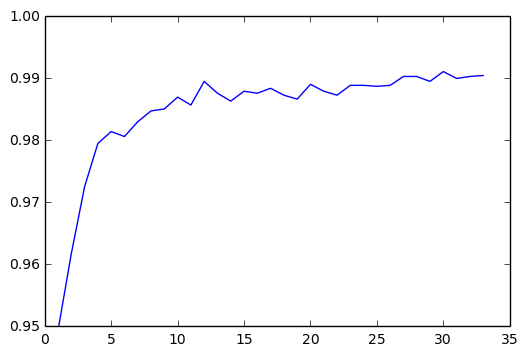

In [42]:
# plot validation accuracy
plt.gca().set_ylim(bottom=0.95, top=1)
plt.plot(accuracy_history)

In [27]:
# read test data
test_features = read_features_from_csv('test.csv', usecols=None)

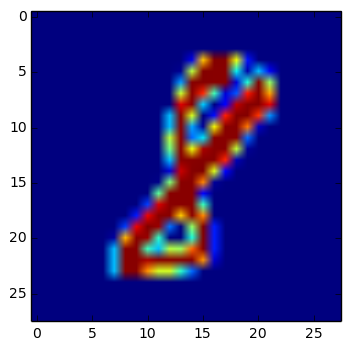

In [28]:
# validate one image
test_index = 123
plt.imshow(np.reshape(test_features[test_index], (28, 28)))

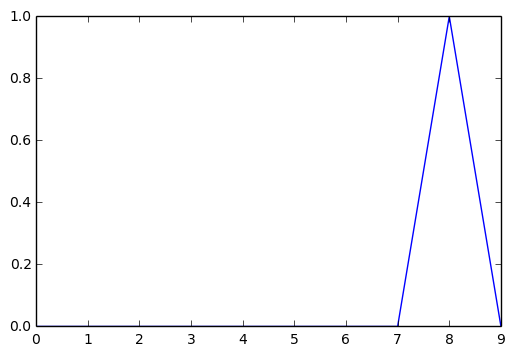

In [29]:
readout = model.get_readout([test_features[test_index]])
plt.plot(readout[0])

In [ ]:
# looks right!

#### Create Submission File

In [43]:
# run model on test data
readout = model.get_readout(test_features)

# convert softmax predictions to label
readout = np.argmax(readout, axis=1)
                    
# add digit ids
readout = [np.arange(1, 1 + len(readout)), readout]
readout = np.transpose(readout)

In [44]:
# write to csv file
np.savetxt('submission-deep-b.csv', readout, fmt='%i,%i', header='ImageId,Label', comments='')